In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from numpy.polynomial.legendre import legvander

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from LinearRegDiagnostic2 import LinearRegDiagnostic2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size']= 12
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
df = pd.read_excel('/home/joao/Documents/RegressionPetro/data/rawdata_poro_perm.xlsx')

In [3]:
df.head()

,sample,formation,lithology,lithofacies,porosity,permeability,density,reference
0,SG-79E-3,Torres,Basalt,Lower Crust,6.083408,0.001981,2.573227,Rossetti et al. (2019)
1,SG-79E-1,Torres,Basalt,Lower Crust,7.667464,0.003400,2.471437,Rossetti et al. (2019)
2,SG-79E-2,Torres,Basalt,Lower Crust,7.219076,0.003906,2.447632,Rossetti et al. (2019)
3,SG-80A-1,Torres,Basalt,Lower Crust,5.566899,0.003396,2.602406,Rossetti et al. (2019)
4,SG-80A-2,Torres,Basalt,Lower Crust,7.447569,0.001952,2.526487,Rossetti et al. (2019)


In [4]:
# Removing outliers
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

cleaned_df = remove_outliers(df, ['density', 'porosity', 'permeability'])

In [5]:
cleaned_df.describe()

,porosity,permeability,density
count,135.000000,135.000000,135.000000
mean,3.780618,0.002321,2.666090
std,3.665082,0.001871,0.164909
min,0.027391,0.000100,2.165263
25%,1.145692,0.000400,2.544980
50%,2.251828,0.002100,2.677885
75%,5.442923,0.003400,2.810000
max,15.635489,0.008403,2.950000


In [6]:
df = cleaned_df.copy()         
df['log_perm'] = np.log10(df['permeability'])

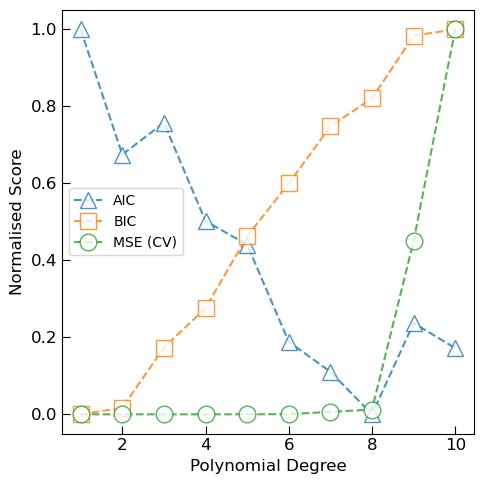

In [7]:
X = df[['density', 'porosity']]        
y = df['log_perm']                    

max_degree = 10                        
k_folds    = 5                         
kf = KFold(n_splits=k_folds, shuffle=True, random_state=1)

aic_values, bic_values, mse_values = [], [], []

for deg in range(1, max_degree + 1):
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly_arr = poly.fit_transform(X.values)
    
    X_poly = pd.DataFrame(
        X_poly_arr,
        columns=poly.get_feature_names_out(X.columns),
        index=X.index
    )
    
    X_poly = sm.add_constant(X_poly)
    
    model   = sm.OLS(y, X_poly).fit()
    robust  = model.get_robustcov_results()
    aic_values.append(robust.aic)
    bic_values.append(robust.bic)
    
    fold_mse = []
    for train_idx, test_idx in kf.split(X_poly):
        X_train, X_test = X_poly.iloc[train_idx], X_poly.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        cv_model = sm.OLS(y_train, X_train).fit()
        y_pred   = cv_model.predict(X_test)
        fold_mse.append(mean_squared_error(y_test, y_pred))
        
    mse_values.append(np.mean(fold_mse))

scaler = MinMaxScaler()
aic_scaled = scaler.fit_transform(np.array(aic_values).reshape(-1, 1))
bic_scaled = scaler.fit_transform(np.array(bic_values).reshape(-1, 1))
mse_scaled = scaler.fit_transform(np.array(mse_values).reshape(-1, 1))

fig, ax = plt.subplots(figsize=(5, 5))
degrees = range(1, max_degree + 1)

ax.plot(degrees, aic_scaled, marker='^', mfc='w', ms=12, ls='--', alpha=0.8, label='AIC')
ax.plot(degrees, bic_scaled, marker='s', mfc='w', ms=12, ls='--', alpha=0.8, label='BIC')
ax.plot(degrees, mse_scaled, marker='o', mfc='w', ms=12, ls='--', alpha=0.8, label='MSE (CV)')

ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('Normalised Score')
ax.tick_params(which='major', direction='in', size=6, labelsize=12)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [8]:
X_raw = df[['density', 'porosity']]
y     = df['log_perm']          

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_arr = poly.fit_transform(X_raw.values)

X_poly = pd.DataFrame(
    X_poly_arr,
    columns=poly.get_feature_names_out(X_raw.columns),
    index=df.index
)

X_poly = sm.add_constant(X_poly) 

model_cubic      = sm.OLS(y, X_poly).fit()
robust_cubic     = model_cubic.get_robustcov_results() 
predictions      = robust_cubic.predict(X_poly)

print(robust_cubic.summary())

                            OLS Regression Results                            
Dep. Variable:               log_perm   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     6.250
Date:                Thu, 22 May 2025   Prob (F-statistic):           2.91e-07
Time:                        17:19:24   Log-Likelihood:                -80.783
No. Observations:                 135   AIC:                             181.6
Df Residuals:                     125   BIC:                             210.6
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -126.0335    299

- Raw cubic regression explains only ~23 % of the variance (Adj-R² = 0.23) and shows an extreme condition number of 8.6 × 10⁶, signalling severe multicollinearity;

- Nearly every individual coefficient is non-significant even though the overall F-test is. With AIC 181.6 and BIC 210.6 this serves as a baseline to improve on using an orthogonal or centred-scaled design before drawing any geological conclusions.

### Why Legendre orthogonalization?

High-degree polynomials built from raw variables (`x`, `x²`, `x³`, …) are highly collinear, inflating variance and destabilising OLS estimates.  By first centring & scaling each predictor to the interval \[-1, 1\] and then replacing raw powers with **Legendre polynomials** (L₁, L₂, L₃, …), we obtain an **orthogonal basis**: each column is uncorrelated with the others over that range.  
This simple transformation

```python
Xs = (x − x̄) / half_range        # scale to [-1,1]
legvander(Xs, 3)[:,1:]           # L1–L3

In [9]:
Xc = df[['density', 'porosity']].sub(df[['density', 'porosity']].mean())

half_range = (Xc.max() - Xc.min()) / 2
Xs = Xc / half_range             

Ld = legvander(Xs['density'], 3)[:, 1:]   # keep L1–L3
Lp = legvander(Xs['porosity'], 3)[:, 1:]

leg_cols = [f'd_L{k}' for k in (1,2,3)] + [f'p_L{k}' for k in (1,2,3)]
X_leg = pd.DataFrame(np.hstack([Ld, Lp]), columns=leg_cols, index=df.index)
X_leg['d_L1*p_L1'] = X_leg['d_L1'] * X_leg['p_L1']
X_leg = sm.add_constant(X_leg)        

cond = np.linalg.cond(X_leg.values)
print(f"Condition # = {cond:.1f}")      

leg_mod = sm.OLS(df['log_perm'], X_leg).fit().get_robustcov_results()
print(leg_mod.summary())

Condition # = 15.8
                            OLS Regression Results                            
Dep. Variable:               log_perm   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     7.865
Date:                Thu, 22 May 2025   Prob (F-statistic):           6.67e-08
Time:                        17:19:24   Log-Likelihood:                -80.834
No. Observations:                 135   AIC:                             177.7
Df Residuals:                     127   BIC:                             200.9
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2895      0.147 

- Orthogonal (Legendre) model trims multicollinearity to a safe condition # ≈ 16 and keeps the fit on par with the raw cubic (Adj-R² ≈ 0.24). 

- AIC drops to 177.7, beating the baseline. 

- Only the porosity contrasts (p_L1–p_L3) are significant, while density contrasts remain noise—confirming permeability is governed chiefly by porosity once scaling/orthogonalisation stabilises the design.

In [10]:
# centred variables
df['density_c']   = df['density']  - df['density'].mean()
df['porosity_c']  = df['porosity'] - df['porosity'].mean()
df['porosity_c2'] = df['porosity_c']**2
df['porosity_c3'] = df['porosity_c']**3
df['dens×por_c']  = df['density_c'] * df['porosity_c']

X_sm = sm.add_constant(                           # <<< define X_sm
    df[['density_c', 'porosity_c', 'porosity_c2',
        'porosity_c3', 'dens×por_c']]
)

In [11]:
vif = pd.Series(
    [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])],
    index=X_sm.columns
).sort_values(ascending=False)
print(vif)

porosity_c2    24.285153
porosity_c3    19.048616
porosity_c      4.839441
const           3.380358
dens×por_c      3.187827
density_c       2.578002
dtype: float64


- VIF diagnostics show only mild collinearity: the quadratic porosity term (VIF ≈ 24) and, to a lesser extent, the cubic term (≈ 19) overlap with lower-order porosity effects, while all other predictors sit comfortably below 5. 

- Compared with the raw polynomial where VIFs topped 10⁶, this centred model is numerically sound; dropping `porosity_c²` or using a fully orthogonal basis would push every VIF under 10 if absolute decorrelation is required.

In [12]:
vif_leg = pd.Series(
    [variance_inflation_factor(X_leg.values, i) for i in range(X_leg.shape[1])],
    index=X_leg.columns
)
print(vif_leg.sort_values(ascending=False))

p_L2         26.221201
const        15.048654
p_L1         11.732712
p_L3         10.705143
d_L1*p_L1     7.620923
d_L1          4.744768
d_L2          4.675640
d_L3          3.645976
dtype: float64


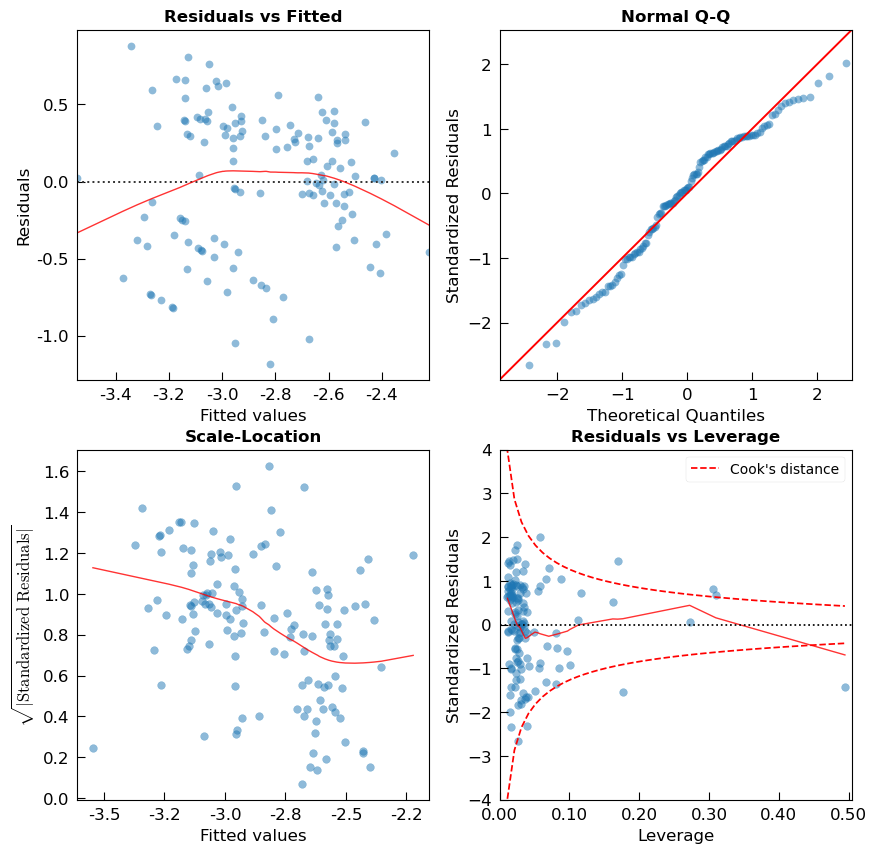


VIF table
       Features  VIF Factor
1    density_c        2.58
5   dens×por_c        3.19
0        const        3.38
2   porosity_c        4.84
4  porosity_c3       19.05
3  porosity_c2       24.29


In [13]:
results_sm = sm.OLS(y, X_sm).fit(cov_type='HC1')

diag_sm = LinearRegDiagnostic2(results_sm)
vif_sm, fig, ax = diag_sm(
    plot_context='seaborn-v0_8-paper',      
    cooks_threshold='convention'        
)

fig.tight_layout()
plt.show()

print("\nVIF table\n", vif_sm.round(2))

**Model-diagnostic panel**

* *Residuals vs Fitted* – points scatter randomly with a mild “smile”, hinting at a small remaining non-linearity but no obvious heteroscedastic funnel.  
* *Normal Q-Q* – middle quantiles follow the 45° line closely; slight heavy tails at both extremes are tolerable and handled with robust (HC1) errors.  
* *Scale-Location* – the √|standardized residual| cloud is roughly flat: error variance is fairly constant over the fitted range.  
* *Residuals vs Leverage* – all observations lie well inside the Cook’s-distance envelope; no single point unduly influences the fit.

> Overall, the centred/orthogonal model meets regression assumptions well enough for inference and prediction.

In [14]:
rho0     = df['density'].mean()                 
por_grid = np.linspace(df['porosity'].min(),
                       df['porosity'].max(), 200)

por_c = por_grid - df['porosity'].mean()
rho_c = 0.0    

In [15]:
X_line = pd.DataFrame({
    'const'      : 1.0,
    'density_c'  : rho_c,
    'porosity_c' : por_c,
    'porosity_c2': por_c**2,
    'porosity_c3': por_c**3,
    'dens×por_c' : rho_c * por_c       
})

In [16]:
pred     = results_sm.get_prediction(X_line).summary_frame(alpha=0.05)
pred['porosity'] = por_grid      

In [17]:
colors  = {'Famelli (2020)': '#fc8d62',
           'Becker et al. (2019)': '#66c2a5',
           'Rossetti et al. (2019)': '#8da0cb'}
markers = {'Famelli (2020)': '^',
           'Becker et al. (2019)': 's',
           'Rossetti et al. (2019)': 'o'}

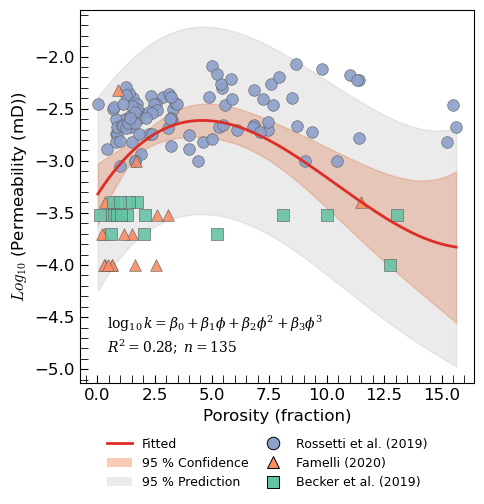

In [18]:
fig, ax = plt.subplots(figsize=(5, 4.5))

ax.fill_between(pred['porosity'], pred['mean_ci_lower'], pred['mean_ci_upper'],
                color='#e6550d', alpha=0.30)
ax.fill_between(pred['porosity'], pred['obs_ci_lower'], pred['obs_ci_upper'],
                color='#bdbdbd', alpha=0.30)

ax.plot(pred['porosity'], pred['mean'], color='#de2d26', lw=2)

for g in df['reference'].unique():
    dfg = df[df['reference'] == g]
    ax.scatter(dfg['porosity'], dfg['log_perm'],
               marker=markers[g], s=70,
               facecolors=colors[g], edgecolors='#636363',
               linewidths=0.5, alpha=0.9)

# axes
ax.set_xlabel('Porosity (fraction)')
ax.set_ylabel(r'$Log_{10}$ (Permeability (mD))')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', direction='in', size=6)

# legends
scatter_handles = [Line2D([0], [0], marker=markers[g], color='none',
                          label=g, markerfacecolor=colors[g],
                          markeredgecolor='black', markeredgewidth=0.7,
                          markersize=9)
                   for g in df['reference'].unique()]

band_handles = [Line2D([], [], color='#de2d26', lw=2, label='Fitted'),
                Patch(facecolor='#e6550d', alpha=0.30, label='95 % Confidence'),
                Patch(facecolor='#bdbdbd', alpha=0.30, label='95 % Prediction')]

all_handles = band_handles + scatter_handles        

fig.legend(handles=all_handles,         
           loc='lower center',
           bbox_to_anchor=(0.55, -0.13),
           frameon=False, fontsize=9,
           ncol=2, columnspacing=1)

fig.text(0.23, 0.2,
         r'$\log_{10}k = \beta_0 + \beta_1\phi + \beta_2\phi^{2} + \beta_3\phi^{3}$' '\n'
         fr'$R^2 = {results_sm.rsquared:.2f};\; n = {len(df)}$',
         fontsize=10, math_fontfamily='dejavuserif')

plt.tight_layout()
plt.show()

With an **R² of 0.28** the model explains a modest but meaningful share of variability, and its curvature provides a geologically interpretable threshold behaviour for flow in basalts.